In [114]:
mass = 3 #kg
gravity = 10 #m/s^2
magnet_force = 2000 #N
percent_weight_on_wheels = 0.8

normal_on_wheel = (mass * gravity + magnet_force) * percent_weight_on_wheels / 2

friction_coef_wheel = 1.0
friction_coef_wedge = 0.5
wedge_friction = (mass * gravity + magnet_force) * (1-percent_weight_on_wheels) * friction_coef_wedge
max_force_on_wheel = normal_on_wheel * friction_coef_wheel
print(f'Maximum force wheel can excert before sliping is {max_force_on_wheel} N')
print(f'Friction force on wedge is {wedge_friction} N')


Maximum force wheel can excert before sliping is 812.0 N
Friction force on wedge is 202.99999999999994 N


In [115]:
wheel_radius = 0.02 #40mm diameter
max_torque_on_wheel = max_force_on_wheel * wheel_radius
print(f'Maximum torque wheel can excert before sliping is {max_torque_on_wheel} N.m')

Maximum torque wheel can excert before sliping is 16.240000000000002 N.m


In [116]:
gear_ratio = 50/11
max_torque_on_motor = max_torque_on_wheel / gear_ratio
print(f'Maximum torque on motor is {max_torque_on_motor} N.m')

Maximum torque on motor is 3.5728 N.m


## From Maxon DCX35L  18V Datasheet
Stall Current = 84.8 A

Torque Constant = 23.4 mNm/A

Speed Constant = 408 RPM/V

Speed/torque gradient =  3.7 RPM/mNm

Rotor inertia = 102 gcm^2

Terminal resistance = 0.212 Ohn

In [117]:
motor_resistance = 0.212
kv = 408/60
kt = 23.4 / 1000
motor_L = 0.077 / 1000
def getMotorTorque(voltage_input, motor_rotation, current_derivative = 0):    
    current = (voltage_input-motor_rotation/kv - current_derivative * motor_L) /motor_resistance
    rotor_torque = current * kt
    return rotor_torque, current

In [118]:
rs775_resistance = 42/46.17
rs775_kv = 345/60
rs775_kt = 0.028
def get775Torque(voltage_input, motor_rotation):
    current = (voltage_input-motor_rotation/rs775_kv) /rs775_resistance
    rotor_torque = current * rs775_kt
    return rotor_torque, current

In [119]:
from matplotlib import pyplot as plt

Stable at 0.0054 seconds, with 54 steps


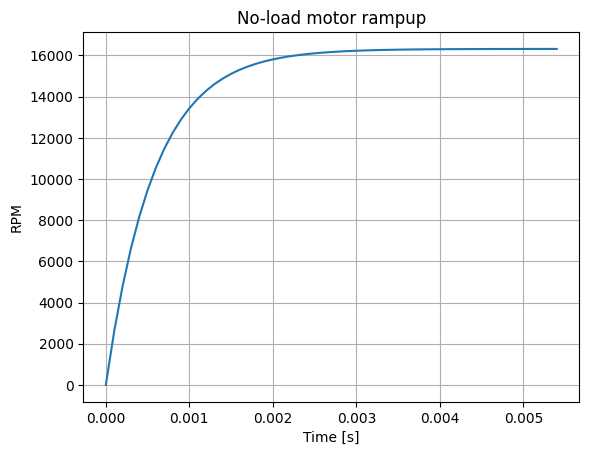

In [120]:
# Motor no-load simulation
timestep = 0.0001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
voltage = 40
motor_inertia = 102 /1000 /100/100
vt_grad = 3.7 / 60
motor_rpm = [0]
t = [0]
unstable = 2
i = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
    step_torque, _ = getMotorTorque(voltage, motor_rotation[-1])
    motor_torque.append(step_torque)
    motor_a.append(step_torque/motor_inertia)
    motor_rpm.append(motor_rotation[-1]*60)
    t.append(i*timestep)
    if len(t)>10 and (max(motor_rotation[-10:]) - min(motor_rotation[-10:])) < 0.1:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    i+=1
plt.plot(t, motor_rpm)
plt.title("No-load motor rampup")
plt.ylabel("RPM")
plt.xlabel("Time [s]")
plt.grid()





Stable at 0.0135 seconds, with 135 steps

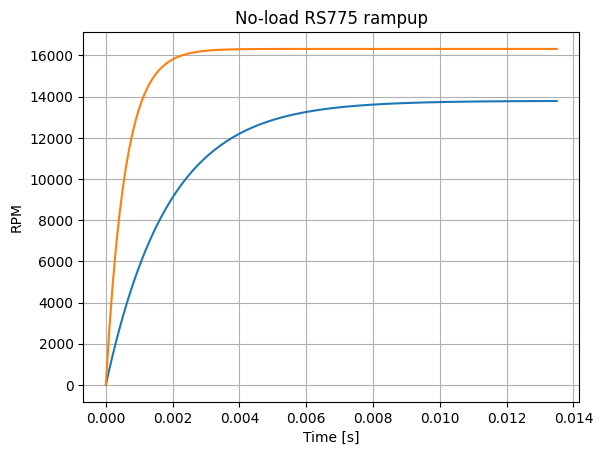

In [121]:
# Motor no-load simulation
compare_rpm = motor_rpm.copy()
timestep = 0.0001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
voltage = 40
motor_inertia = 102 /1000 /100/100
motor_rpm = [0]
t = [0]
unstable = 2
i = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
    step_torque, _ = get775Torque(voltage, motor_rotation[-1])
    motor_torque.append(step_torque)
    motor_a.append(step_torque/motor_inertia)
    motor_rpm.append(motor_rotation[-1]*60)
    t.append(i*timestep)
    if len(t)>10 and (max(motor_rotation[-10:]) - min(motor_rotation[-10:])) < 0.1:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    i+=1
while(len(compare_rpm)<len(t)):
    compare_rpm.append(compare_rpm[-1])
plt.plot(t, motor_rpm)
plt.plot( t, compare_rpm)
plt.title("No-load RS775 rampup")
plt.ylabel("RPM")
plt.xlabel("Time [s]")
plt.grid()


Stable at 0.003 seconds, with 3000 steps


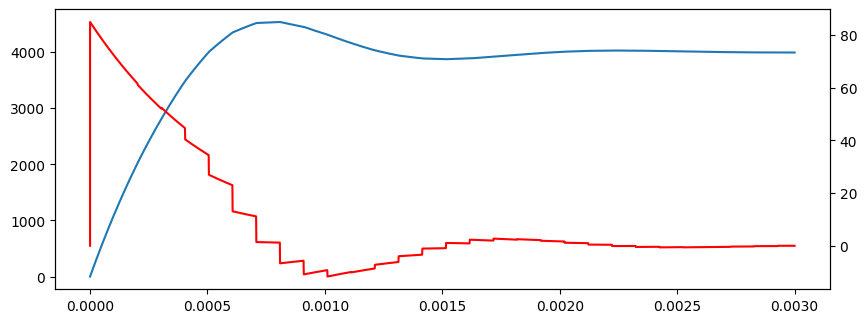

In [122]:
# Speed controller
freq_setpoint = 4000/60
timestep = 0.000001 #s
motor_a = [0]
motor_rotation = [0]
motor_torque = [0]
motor_current=[0]
voltage = 18
motor_inertia = 102 /1000 /100/100
motor_rpm = [0]
t = [0]
unstable = 2
i = 0

controller_period = 0.0001
Kp = 0.01
Ki = 100
error_integral = 0
controller_tick = -1
controller_output = 0
controller_output_saturation = 0
controller_past_error = 0
while unstable:
    motor_rotation.append(motor_rotation[-1]+motor_a[-1]*timestep)
### Controller
    if t[-1] > controller_tick + controller_period:
        error = freq_setpoint - motor_rotation[-1]
        if not controller_output_saturation:
            error_integral += error * controller_period
        error_derivative = error-controller_past_error / controller_period


        controller_output = error * Kp + error_integral * Ki 
        controller_tick = t[-1]
        controller_past_error = error
        if controller_output > 1:
            controller_output = 1
            controller_output_saturation = 1
        elif controller_output < -1:
            controller_output = -1
            controller_output_saturation = 1
        else:
            controller_output_saturation = 0
###
    

    step_torque, step_current = getMotorTorque(voltage * controller_output, motor_rotation[-1]) 
    # step_torque -= 0.5
    motor_torque.append(step_torque)
    motor_a.append(step_torque/(motor_inertia))
    motor_rpm.append(motor_rotation[-1]*60)
    motor_current.append(step_current)
    t.append(i*timestep)
    if len(t)>100 and (max(motor_rotation[-100:]) - min(motor_rotation[-100:])) < 0.01:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    elif i==10000000: #max steps
        unstable = 0
    i+=1

plt.figure(figsize=(10,8))
ax0 = plt.subplot(211)
ax1 = ax0.twinx()
ax0.plot(t, motor_rpm)
ax1.plot(t, motor_current, "red")
plt.show()

Stable at 0.0443 seconds, with 443 steps


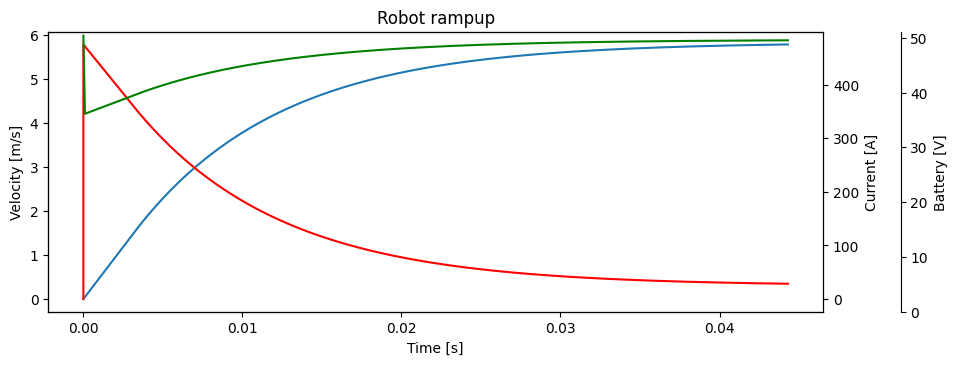

In [123]:
# Robot rampup
timestep = 0.0001 #s
a = [0]
v = [0]
x = [0]
force = [0]
voltage = 12 * 4.2
baterry_resistance = 30 / 1000
gear_ratio = 7
motor_inertia = 102 /1000 /100/100
I_motor = 0.00000007 + motor_inertia
I_wheel = 0.00001513 + 0.00004473 
I_eq = I_motor + I_wheel/(gear_ratio**2)
robot_speed = [0]
t = [0]
unstable = 2
i = 0
robot_current = [0]
bat = [voltage]
max_a = (2 * max_force_on_wheel - wedge_friction)/mass

while unstable:
    step_voltage = voltage - robot_current[-1]*baterry_resistance
    bat.append(step_voltage)
    v.append(v[-1] + a[-1] * timestep)
    x.append(x[-1] + v[-1] * timestep)
    wheel_speed = v[-1]/(2 * 3.1415 * wheel_radius)
    motor_torque, motor_current = getMotorTorque(voltage, wheel_speed * gear_ratio)
    if v[-1] > 0.000001:
        Fa = wedge_friction
    elif v[-1] < -0.000001:
        Fa = -wedge_friction
    else:
        Fa = 0
    step_a = ((2*motor_torque * gear_ratio/wheel_radius/mass)-(Fa/mass))/(1 + (gear_ratio**2 * 2 * I_eq / wheel_radius**2 / mass))
    step_a = min(step_a, max_a)


    a.append(step_a)    
    robot_current.append(2*motor_current)
    t.append(i*timestep)
    if len(t)>10 and (max(v[-10:]) - min(v[-10:])) < 0.005:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    if i > 10000:
        break
    i+=1
plt.figure(figsize=(10,8))
ax0 = plt.subplot(211)
plt.title("Robot rampup")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
ax1 = ax0.twinx()
ax0.plot(t, v)
ax1.plot(t, robot_current, "red")
plt.ylabel("Current [A]")
ax2 = ax0.twinx()
ax2.plot(t,bat, "g")
ax2.spines["right"].set_position(("axes", 1.1))
plt.ylabel("Battery [V]")
plt.ylim(bottom = 0)
plt.show()




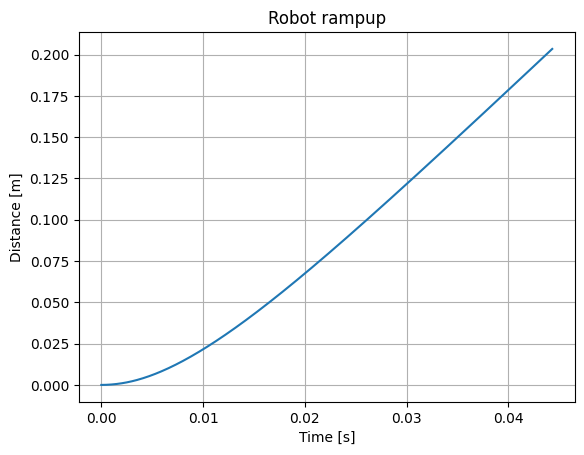

In [124]:
plt.plot(t, x)
plt.title("Robot rampup")
plt.ylabel("Distance [m]")
plt.xlabel("Time [s]")
plt.grid()


Stable at 0.3534 seconds, with 3534 steps


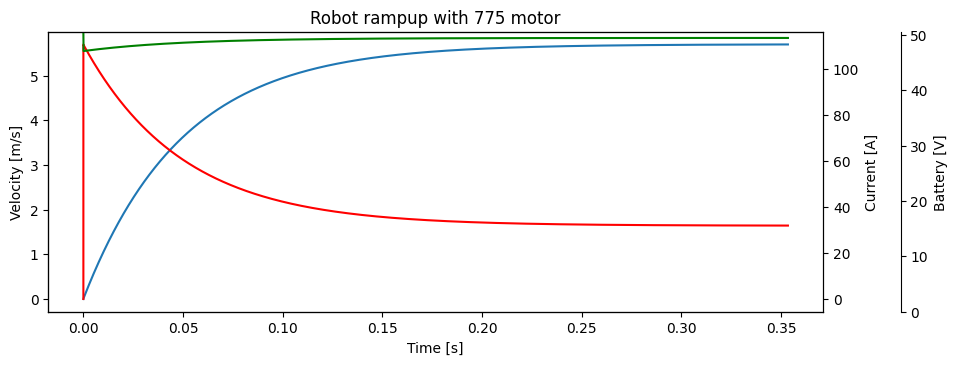

In [125]:
# Robot rampup with RS775
timestep = 0.0001 #s
a = [0]
v = [0]
x = [0]
force = [0]
voltage = 12 * 4.2 
baterry_resistance = 30 / 1000
gear_ratio = 50/11
motor_inertia = 102 /1000 /100/100 #assuming same inertia as the maxon
I_motor = 0.00000007 + motor_inertia
I_wheel = 0.00001513 + 0.00004473 
I_eq = I_motor + I_wheel/(gear_ratio**2)
robot_speed = [0]
t = [0]
unstable = 2
i = 0
robot_current = [0]
bat = [voltage]
max_a = (2 * max_force_on_wheel - wedge_friction)/mass

while unstable:
    step_voltage = voltage - robot_current[-1]*baterry_resistance
    bat.append(step_voltage)
    v.append(v[-1] + a[-1] * timestep)
    x.append(x[-1] + v[-1] * timestep)
    wheel_speed = v[-1]/(2 * 3.1415 * wheel_radius)
    motor_torque, motor_current = get775Torque(voltage, wheel_speed * gear_ratio)
    if v[-1] > 0.000001:
        Fa = wedge_friction
    elif v[-1] < -0.000001:
        Fa = -wedge_friction
    else:
        Fa = 0
    step_a = ((2*motor_torque * gear_ratio/wheel_radius/mass)-(Fa/mass))/(1 + (gear_ratio**2 * 2 * I_eq / wheel_radius**2 / mass))
    step_a = min(step_a, max_a)


    a.append(step_a)    
    robot_current.append(2*motor_current)
    t.append(i*timestep)
    if len(t)>10 and (max(v[-100:]) - min(v[-100:])) < 0.001:
        unstable = 0
        print(f"Stable at {t[-1]} seconds, with {i} steps")
    if i > 10000:
        break
    i+=1
plt.figure(figsize=(10,8))
ax0 = plt.subplot(211)
plt.title("Robot rampup with 775 motor")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
ax1 = ax0.twinx()
ax0.plot(t, v)
ax1.plot(t, robot_current, "red")
plt.ylabel("Current [A]")
ax2 = ax0.twinx()
ax2.plot(t,bat, "g")
ax2.spines["right"].set_position(("axes", 1.1))
plt.ylabel("Battery [V]")
plt.ylim(bottom = 0)
plt.show()




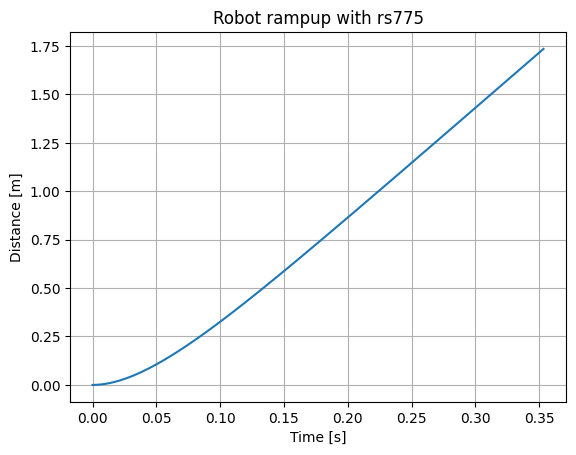

In [126]:
plt.plot(t, x)
plt.title("Robot rampup with rs775")
plt.ylabel("Distance [m]")
plt.xlabel("Time [s]")
plt.grid()